#### CHAPTER 17: _What is Model Drift and Why Do We Care?_
##### From **Building Responsible AI with Python**, published by Packt

## The Preparations

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 8.7 MB/s eta 0:00:00


These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

### Loading the Libraries

In [3]:
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import shap

MAX_FEATURE_IMPORTANCE = 5
RANDOM_SEED = 700
np.random.seed(RANDOM_SEED)

***The code below needs to be replaced with the data file loaded from the Github library for the book***

---



In [4]:
from google.colab import drive
drive.mount ('/content/drive')
project_dir = '/content/drive/MyDrive/Responsible AI Book/Code/Ch17/'
ces = pd.read_csv(project_dir+ 'Ch17-CES.csv')

Mounted at /content/drive


### Prepare DataFrame for processing and Analysis

In [5]:
ces

,CUID,Date,Year,Month,Income Before Taxes,Number of Bedrooms,Number of Bathrooms,State,Urban,People,...,Retired,Education,Race,Sex,Renter,Owner,Food-Away,Food-Home,Food-Total,High lead-Food-Away Spending
0,346096,2017-01-01,2017,1,"110,408.351",2.000,2.000,Tennessee,1,2,...,0,Some College,White,Mixed Gender,0.000,1.000,"1,638.350","1,211.528","2,849.878",0
1,346101,2017-01-01,2017,1,"131,360.855",3.000,1.000,California,1,2,...,0,Bachelors,White,Mixed Gender,0.000,1.000,819.224,"1,269.220","2,088.444",0
2,346107,2017-01-01,2017,1,"235,418.628",2.000,2.000,Pennsylvania,1,2,...,2,Graduate Degree,White,Mixed Gender,1.000,0.000,"2,164.260","2,596.132","4,760.392",1
3,346119,2017-01-01,2017,1,"32,822.578",4.000,2.000,Kentucky,0,2,...,0,High School,White,Mixed Gender,0.000,1.000,224.998,"2,624.978","2,849.976",0
4,346124,2017-01-01,2017,1,"180,812.117",3.000,2.000,Louisiana,1,4,...,2,Some College,White,Mixed Gender,0.000,1.000,351.920,"1,367.296","1,719.216",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8415,457862,2020-11-01,2020,11,"520,951.659",4.000,3.000,Pennsylvania,1,4,...,0,Graduate Degree,Multi or Other Race,Mixed Gender,0.000,1.000,"1,381.428","2,210.285","3,591.713",0
8416,457877,2020-11-01,2020,11,"107,108.371",3.000,2.000,Florida,1,3,...,0,Bachelors,White,Mixed Gender,0.000,1.000,0.000,"2,762.856","2,762.856",0
8417,457916,2020-11-01,2020,11,"43,914.432",1.000,1.000,Texas,1,1,...,0,Some College,Black,Male,1.000,0.000,"1,445.186","1,770.353","3,215.539",0
8418,457922,2020-11-01,2020,11,"164,154.289",2.000,1.000,New York,1,2,...,0,Graduate Degree,Multi or Other Race,Mixed Gender,0.000,1.000,828.857,"2,263.417","3,092.273",0


In [6]:
ces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8420 entries, 0 to 8419
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUID                          8420 non-null   int64  
 1   Date                          8420 non-null   object 
 2   Year                          8420 non-null   int64  
 3   Month                         8420 non-null   int64  
 4   Income Before Taxes           8420 non-null   float64
 5   Number of Bedrooms            8400 non-null   float64
 6   Number of Bathrooms           8400 non-null   float64
 7   State                         8420 non-null   object 
 8   Urban                         8420 non-null   int64  
 9   People                        8420 non-null   int64  
 10  Adults                        8420 non-null   int64  
 11  65 or Older                   8420 non-null   int64  
 12  Children                      8420 non-null   int64  
 13  Wor

In [7]:
# Confirm CUID is unique and can be used as an index
print(ces.shape[0])
print(ces['CUID'].nunique())

8420
8420


### Assign Index and Data Types

In [8]:
ces.set_index("CUID", inplace=True)
ces['Date'] = ces['Date'].astype('datetime64[ns]')
ces['Income Before Taxes'] = ces['Income Before Taxes'].astype('int')
ces['State'] = ces['State'].astype('category')
ces['Education'] = ces['Education'].astype('category')
ces['Race'] = ces['Race'].astype('category')
ces['Sex'] = ces['Sex'].astype('category')
ces['Renter'] = ces['Renter'].astype('category')
ces['Owner'] = ces['Owner'].astype('category')
ces['Urban'] = ces['Urban'].astype('category')
ces["High lead-Food-Away Spending"]=ces["High lead-Food-Away Spending"].astype("category")

In [9]:
ces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8420 entries, 346096 to 457928
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          8420 non-null   datetime64[ns]
 1   Year                          8420 non-null   int64         
 2   Month                         8420 non-null   int64         
 3   Income Before Taxes           8420 non-null   int64         
 4   Number of Bedrooms            8400 non-null   float64       
 5   Number of Bathrooms           8400 non-null   float64       
 6   State                         8420 non-null   category      
 7   Urban                         8420 non-null   category      
 8   People                        8420 non-null   int64         
 9   Adults                        8420 non-null   int64         
 10  65 or Older                   8420 non-null   int64         
 11  Children               

# The Target Label Distribution Drift




In [10]:
ces_2017_2019 = ces[ces['Year'].isin((2017, 2018, 2019))]
ces_Q1_2020 = ces[(ces['Date'] >= '2020-01-01') & (ces['Date'] <= '2020-03-31')]
ces_Q2_2020 = ces[(ces['Date'] >= '2020-04-01') & (ces['Date'] <= '2020-06-30')]
ces_Q3_2020 = ces[(ces['Date'] >= '2020-07-01') & (ces['Date'] <= '2020-09-30')]
ces_Q4_2020 = ces[(ces['Date'] >= '2020-09-01') & (ces['Date'] <= '2020-12-31')]

In [11]:
class_distribution = []

class_distribution.append(["ces_2017_2019", 
                           ces_2017_2019['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[0],
                           ces_2017_2019['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[1]])

class_distribution.append(["ces_Q1_2020", 
                           ces_Q1_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[0],
                           ces_Q1_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[1]])

class_distribution.append(["ces_Q2_2020", 
                           ces_Q2_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[0],
                           ces_Q2_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[1]])

class_distribution.append(["ces_Q3_2020", 
                           ces_Q3_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[0],
                           ces_Q3_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[1]])

class_distribution.append(["ces_Q4_2020", 
                           ces_Q4_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[0],
                           ces_Q4_2020['High lead-Food-Away Spending'].
                           value_counts(normalize=True)[1]])

distdf = pd.DataFrame(class_distribution, 
                      columns=['Period', 
                               'High lead-Food-Away Spending (No = 0)', 
                               'High lead-Food-Away Spending (Yes = 1)']
                      )

distdf.style.background_gradient(cmap='coolwarm')

,Period,High lead-Food-Away Spending (No = 0),High lead-Food-Away Spending (Yes = 1)
0,ces_2017_2019,0.900031,0.099969
1,ces_Q1_2020,0.962121,0.037879
2,ces_Q2_2020,0.940270,0.059730
3,ces_Q3_2020,0.957643,0.042357
4,ces_Q4_2020,0.940325,0.059675


# Model Drift - Drop in Accuracy

In [12]:
model_results = []

def model_acc_metrics(X, y_true, clf, desc):
  
    y_pred = clf.predict(X)
    y_prob = clf_dt.predict_proba(X)[:, 1]
    
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f'Area under ROC curve: {auc: 0.4f}')
    print(f'Accuracy {acc: 0.4f}')
    print(f'Balanced Accuracy {bal_acc: 0.4f}')
    print(f'Weighted F1 score {f1: 0.4f}')
    print(classification_report(y_true, y_pred, digits=4))
    print (pd.DataFrame(confusion_matrix(y_true, y_pred)))

    model_results.append([desc,auc, acc, bal_acc, f1])

In [13]:
def df_pre_processing(dataFrame):
  processed_df = dataFrame.copy()

  #fill missing values
  processed_df['Number of Bathrooms'].fillna(
      processed_df['Number of Bathrooms'].median(), inplace=True)
  processed_df['Number of Bedrooms'].fillna(
      processed_df['Number of Bedrooms'].median(), inplace=True)

  #encode categorical features
  Education_ohe = pd.get_dummies(processed_df.Education, prefix='Education')
  Race_ohe = pd.get_dummies(processed_df.Race, prefix='Race')
  Sex_ohe = pd.get_dummies(processed_df.Sex, prefix='Sex')
  State_ohe = pd.get_dummies(processed_df.State, prefix='State')

  DROP_cat = ['Education', 'Race', 'Sex', 'State']
  processed_df.drop(columns=DROP_cat, inplace=True)

  processed_df = pd.concat([processed_df, Education_ohe], axis=1)
  processed_df = pd.concat([processed_df, Race_ohe], axis=1)
  processed_df = pd.concat([processed_df, Sex_ohe], axis=1)
  processed_df = pd.concat([processed_df, State_ohe], axis=1)
  
  return(processed_df)

In [14]:
def get_labels_data(dataFrame):
  r_labels = dataFrame['High lead-Food-Away Spending']
  r_data = dataFrame.drop(columns=
                          ['Year', 'Date', 'High lead-Food-Away Spending'])
  return r_data, r_labels

### Train/Test split on 2017 through 2019 records - all available states

In [15]:
data, labels = get_labels_data(df_pre_processing(ces_2017_2019))
train, test, labels_train, labels_test = \
  sklearn.model_selection.train_test_split(data, labels, train_size=0.80, 
                                           random_state=RANDOM_SEED)

## Fit Decision Tree Model

In [16]:
clf_dt = DecisionTreeClassifier(criterion="gini", random_state=RANDOM_SEED,
                                max_depth=10, 
                                min_samples_leaf=5,
                                class_weight='balanced')   
clf_dt.fit(train, labels_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, random_state=700)

## Test Accuracy Drift

In [17]:
model_acc_metrics(test, labels_test, clf_dt, "DT Test 2017-2019")

Area under ROC curve:  0.7706
Accuracy  0.8242
Balanced Accuracy  0.7554
Weighted F1 score  0.8494
              precision    recall  f1-score   support

           0     0.9578    0.8415    0.8959      1161
           1     0.3210    0.6692    0.4339       130

    accuracy                         0.8242      1291
   macro avg     0.6394    0.7554    0.6649      1291
weighted avg     0.8937    0.8242    0.8494      1291

     0    1
0  977  184
1   43   87


In [18]:
Q1_data, Q1_labels = get_labels_data(df_pre_processing(ces_Q1_2020))
model_acc_metrics(Q1_data, Q1_labels, clf_dt, "DT Q1 2020")

Area under ROC curve:  0.6462
Accuracy  0.7727
Balanced Accuracy  0.6177
Weighted F1 score  0.8413
              precision    recall  f1-score   support

           0     0.9732    0.7854    0.8693       508
           1     0.0763    0.4500    0.1304        20

    accuracy                         0.7727       528
   macro avg     0.5247    0.6177    0.4999       528
weighted avg     0.9392    0.7727    0.8413       528

     0    1
0  399  109
1   11    9


In [19]:
Q2_data, Q2_labels = get_labels_data(df_pre_processing(ces_Q2_2020))
model_acc_metrics(Q2_data, Q2_labels, clf_dt, "DT Q2 2020")

Area under ROC curve:  0.7970
Accuracy  0.8728
Balanced Accuracy  0.7813
Weighted F1 score  0.8968
              precision    recall  f1-score   support

           0     0.9774    0.8852    0.9290       488
           1     0.2727    0.6774    0.3889        31

    accuracy                         0.8728       519
   macro avg     0.6251    0.7813    0.6590       519
weighted avg     0.9353    0.8728    0.8968       519

     0   1
0  432  56
1   10  21


In [20]:
Q3_data, Q3_labels = get_labels_data(df_pre_processing(ces_Q3_2020))
model_acc_metrics(Q3_data, Q3_labels, clf_dt, "DT Q3 2020")

Area under ROC curve:  0.7133
Accuracy  0.8471
Balanced Accuracy  0.7124
Weighted F1 score  0.8864
              precision    recall  f1-score   support

           0     0.9781    0.8596    0.9150       520
           1     0.1512    0.5652    0.2385        23

    accuracy                         0.8471       543
   macro avg     0.5646    0.7124    0.5768       543
weighted avg     0.9431    0.8471    0.8864       543

     0   1
0  447  73
1   10  13


In [21]:
Q4_data, Q4_labels = get_labels_data(df_pre_processing(ces_Q4_2020))
model_acc_metrics(Q4_data, Q4_labels, clf_dt, "DT Q4 2020")

Area under ROC curve:  0.7006
Accuracy  0.8336
Balanced Accuracy  0.6987
Weighted F1 score  0.8687
              precision    recall  f1-score   support

           0     0.9672    0.8519    0.9059       520
           1     0.1895    0.5455    0.2812        33

    accuracy                         0.8336       553
   macro avg     0.5784    0.6987    0.5936       553
weighted avg     0.9208    0.8336    0.8687       553

     0   1
0  443  77
1   15  18


In [22]:
resdf = pd.DataFrame(model_results, columns=['time segment', 'auc', 'accuracy', 'balanced accuracy', 'f1-score'])
resdf.style.background_gradient(cmap='coolwarm')

,time segment,auc,accuracy,balanced accuracy,f1-score
0,DT Test 2017-2019,0.770619,0.824167,0.755373,0.849397
1,DT Q1 2020,0.646211,0.772727,0.617717,0.841294
2,DT Q2 2020,0.796999,0.872832,0.781333,0.896769
3,DT Q3 2020,0.713294,0.847145,0.712416,0.886391
4,DT Q4 2020,0.700641,0.833635,0.698689,0.868653


# Check Logical Consistency - Feature Importance

## Model Specific Feature Importance

In [23]:
dt_ft = dict(zip(data.columns, clf_dt.feature_importances_))
dt_feat_df = pd.DataFrame(dt_ft.items(), columns=['Feature', 'Coef'])
top_dt_feat_df = dt_feat_df.sort_values(by='Coef', ascending=False).iloc[:MAX_FEATURE_IMPORTANCE,:]  
top_dt_feat_df.style.background_gradient(cmap='coolwarm')

,Feature,Coef
13,Food-Away,0.650373
1,Income Before Taxes,0.094601
15,Food-Total,0.058188
14,Food-Home,0.045146
0,Month,0.023979


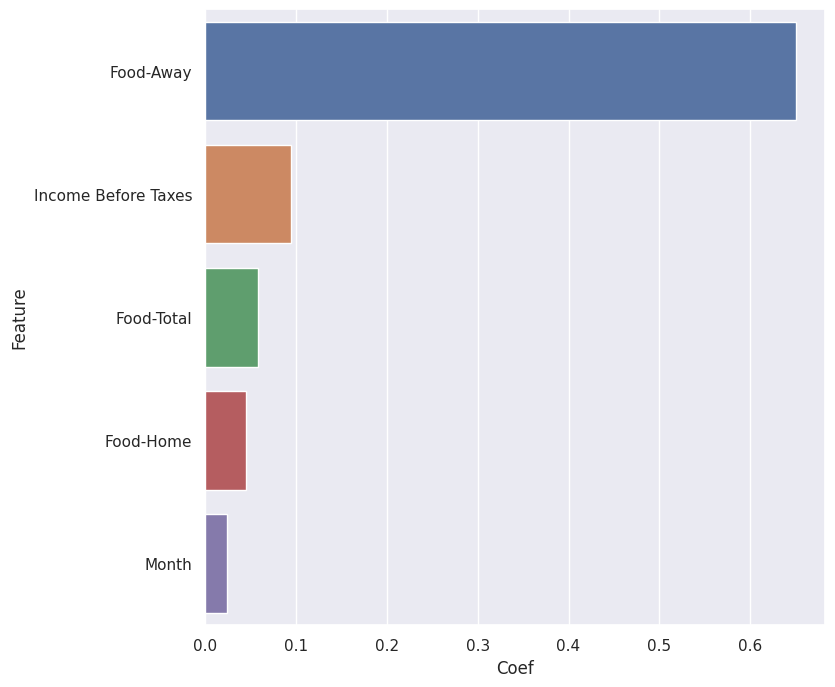

In [172]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.barplot(x=top10_dt_feat_df.Coef, y = top_dt_feat_df.Feature, orient='h')
plt.show()

## Model Agnostic Feature Importance

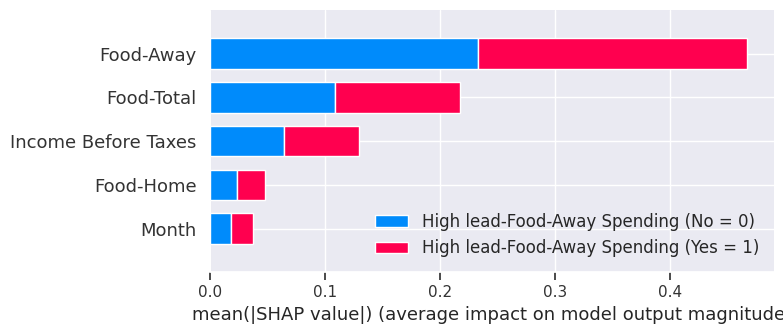

In [174]:
shapTreeExplainer = shap.TreeExplainer(clf_dt)

shap.summary_plot(shapTreeExplainer.shap_values(test),
                  test, 
                  feature_names=test.columns,  
                  max_display=MAX_FEATURE_IMPORTANCE, 
                  class_names=['High lead-Food-Away Spending (No = 0)', 
                               'High lead-Food-Away Spending (Yes = 1)'])

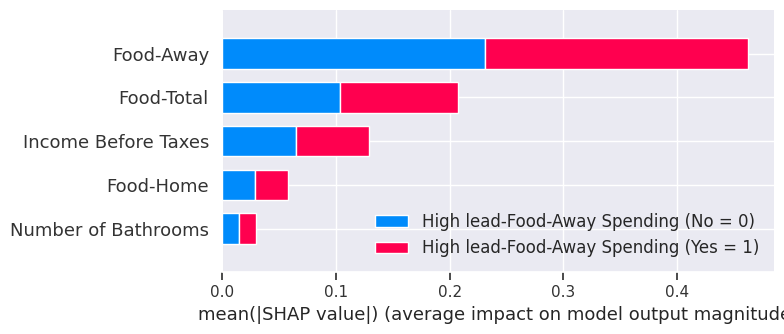

In [175]:
shap.summary_plot(shapTreeExplainer.shap_values(Q1_data),
                  Q1_data, 
                  feature_names=Q1_data.columns,  
                  max_display=MAX_FEATURE_IMPORTANCE,
                  class_names=['High lead-Food-Away Spending (No = 0)', 
                               'High lead-Food-Away Spending (Yes = 1)'])

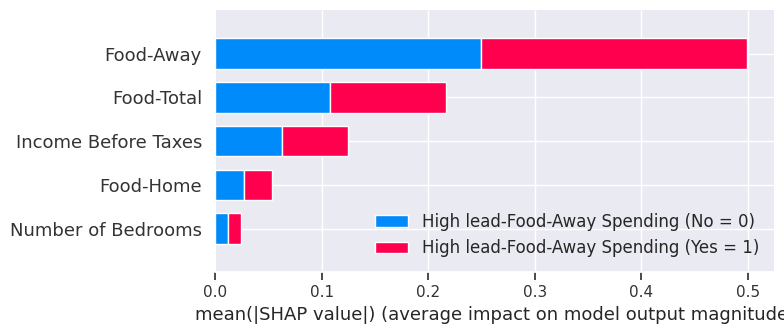

In [176]:
shap.summary_plot(shapTreeExplainer.shap_values(Q2_data),
                  Q2_data, 
                  feature_names=Q2_data.columns, 
                  max_display=MAX_FEATURE_IMPORTANCE,
                  class_names=['High lead-Food-Away Spending (No = 0)', 
                               'High lead-Food-Away Spending (Yes = 1)'])

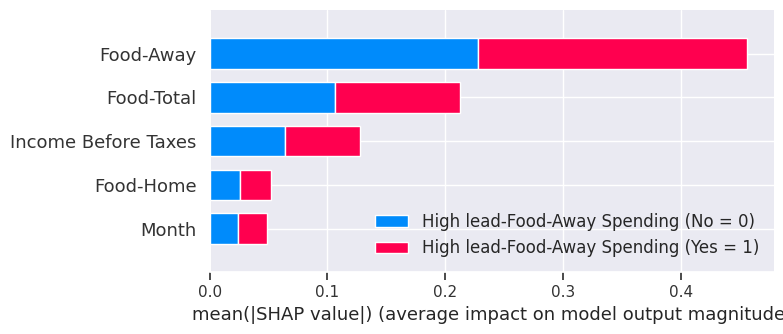

In [177]:
shap.summary_plot(shapTreeExplainer.shap_values(Q4_data),
                  Q4_data, 
                  feature_names=Q4_data.columns,  
                  max_display=MAX_FEATURE_IMPORTANCE,
                  class_names=['High lead-Food-Away Spending (No = 0)', 
                               'High lead-Food-Away Spending (Yes = 1)'])

# Top Predictive Feature Drift 

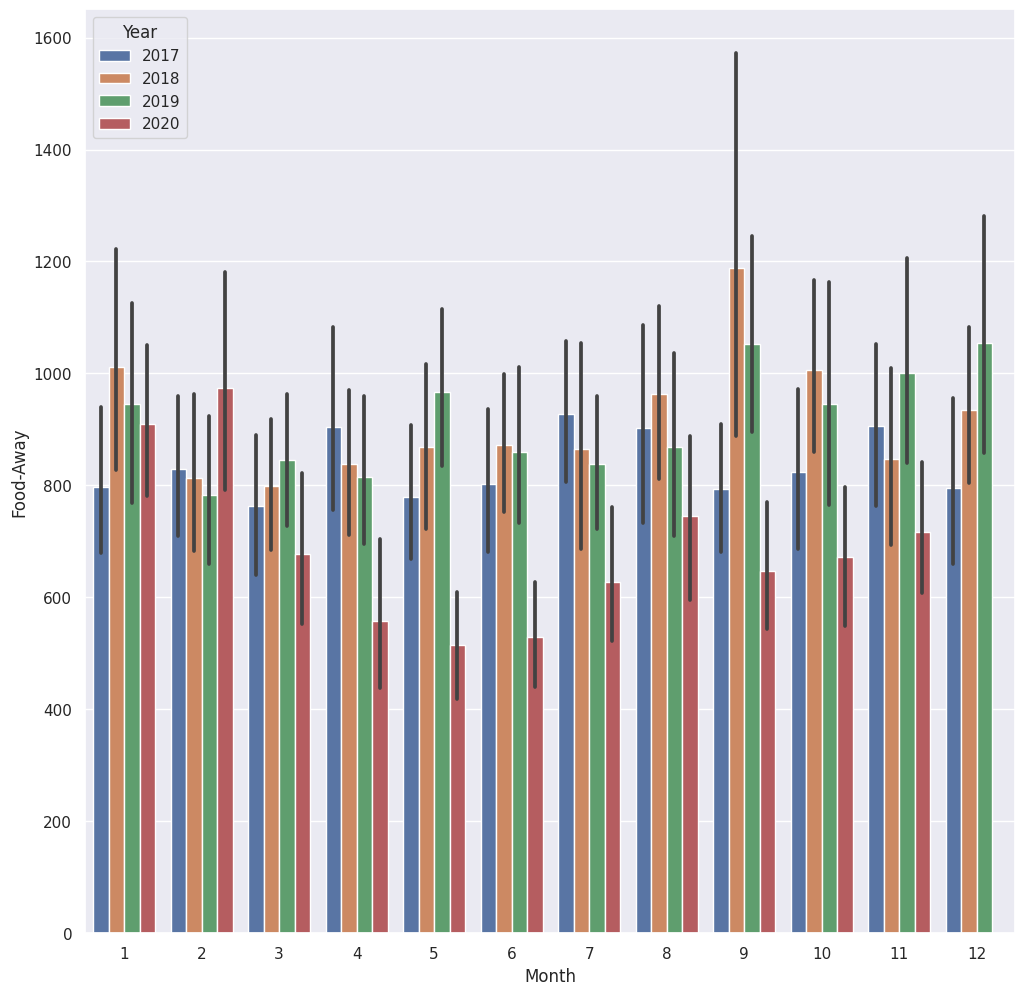

In [178]:
sns.set(rc={"figure.figsize":(12, 12)}) 
sns.barplot(x = 'Month', y = 'Food-Away', hue = 'Year', data = ces)
plt.show()

### Visualize Quarterly Summaries for all available states

In [179]:
# add Quarter column to the data frame
ces.insert(loc=3, column='Quarter', value=np.nan)
ces['Quarter'] = ces['Month'].apply(lambda x: (x - 1) // 3 + 1)
ces.sample(3)

,Date,Year,Month,Quarter,Income Before Taxes,Number of Bedrooms,Number of Bathrooms,State,Urban,People,...,Retired,Education,Race,Sex,Renter,Owner,Food-Away,Food-Home,Food-Total,High lead-Food-Away Spending
CUID,,,,,,,,,,,,,,,,,,,,,
398862,2018-11-01,2018,11,4,143568,2.000,1.000,New York,1,2,...,0,Bachelors,White,Mixed Gender,1.000,0.000,365.069,584.110,949.179,0
355128,2017-05-01,2017,5,2,115083,4.000,3.000,South Carolina,1,4,...,0,Bachelors,White,Mixed Gender,0.000,1.000,"3,148.451","3,337.358","6,485.809",1
427559,2020-03-01,2020,3,1,156294,3.000,2.000,South Carolina,1,2,...,0,Graduate Degree,White,Mixed Gender,0.000,1.000,"1,774.624","3,563.445","5,338.070",1


In [180]:
ces_qtly = ces.groupby(["Year", "Quarter"])["Food-Away",
                                            "Food-Home", 
                                            "Food-Total", 
                                            "High lead-Food-Away Spending"].sum()
ces_qtly

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Food-Away   Food-Home    Food-Total
Year Quarter                                      
2017 1       459,851.370 936,148.968 1,396,000.338
     2       456,421.335 937,805.901 1,394,227.235
     3       487,253.842 901,349.812 1,388,603.655
     4       484,434.239 882,863.461 1,367,297.700
2018 1       474,380.669 876,445.658 1,350,826.327
     2       459,031.065 928,724.215 1,387,755.280
     3       492,432.049 824,458.293 1,316,890.343
     4       499,831.035 937,409.996 1,437,241.031
2019 1       458,330.696 877,642.185 1,335,972.881
     2       453,516.387 855,714.791 1,309,231.179
     3       472,858.730 853,880.120 1,326,738.850
     4       534,406.690 916,269.180 1,450,675.870
2020 1       450,281.764 915,647.759 1,365,929.523
     2       277,018.971 974,380.963 1,251,399.934
     3       365,744.502 971,213.854 1,336,958.356
     4       263,202.022 670,371.836   933,573.858

In [181]:
ces_qtly = ces_qtly.reset_index()
ces_qtly.sample(3)

,Year,Quarter,Food-Away,Food-Home,Food-Total
5,2018,2,"459,031.065","928,724.215","1,387,755.280"
3,2017,4,"484,434.239","882,863.461","1,367,297.700"
14,2020,3,"365,744.502","971,213.854","1,336,958.356"


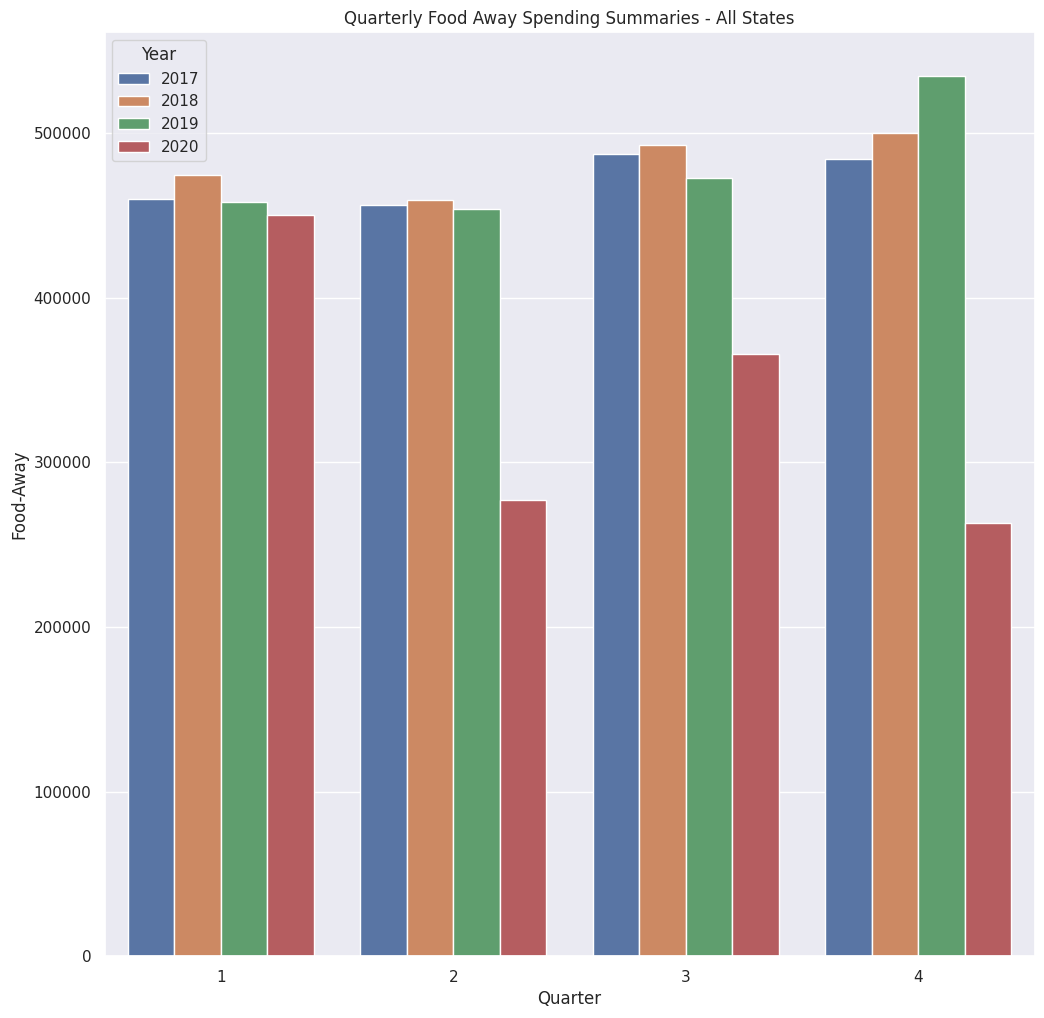

In [182]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set_title('Quarterly Food Away Spending Summaries - All States')

sns.barplot(x = 'Quarter', y = 'Food-Away',
            hue = 'Year',
            data = ces_qtly)
fig.show()